<a href="https://colab.research.google.com/github/longevity-genie/just-agents/blob/main/examples/notebooks/05_embeddings_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings explained

It is the fifth tutorial in a series of tutorials:
1. Basic agents tutorial
2. Database agent tutorial
3. Coding agent tutorial
4. Multiagent patterns
5. Embeddings and Semantic Search  (THIS ONE)

### Optional theoretical information

If you're interested in more background, you might find these useful:
* 3Blue1Brown playlist on transformers: https://www.youtube.com/watch?v=LPZh9BOjkQs&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=5
* DeepLearning.AI MCP course: https://www.deeplearning.ai/short-courses/mcp-build-rich-context-ai-apps-with-anthropic/
* DeepLearning.AI course on embeddings: https://www.deeplearning.ai/short-courses/embedding-models-from-architecture-to-implementation/
* Genomic models paper: https://www.biorxiv.org/content/10.1101/2025.03.27.645711v1


Let's add some theory from BlueBrown video cited above

Most of popular LLM-s are decoder based models meaning that they work like text-completion machines.

<img src="https://3b1b-posts.us-east-1.linodeobjects.com/content/lessons/2024/gpt/predict.png" alt="LLM Token Prediction" width="50%">

Inputs are splitted into tokens and each token has a numeri vector embedding. Those embeddings are learned by LLM-s and they position similar words close to each other that enables us to use this feature in search, classification, clustering and other tasks:

<img src="https://3b1b-posts.us-east-1.linodeobjects.com/content/lessons/2024/gpt/token.png" alt="LLM Token Prediction" width="50%">


For example here relationships between queen, king and gender depicted:

<img src="https://pbs.twimg.com/media/GG3H0boW4AAiSP3?format=jpg&name=large" alt="LLM Token Prediction" width="50%">


## Semantic Similarity Search

When training large language models learned representation of the world, also known as embedding, where each token/word is represented as vector. By computing the distances between this vector we can compare similarity between their semantics. And we can use it in a search by using so-called vector-databases and using cosine distance between vectors as similarity measurement.

There are specialized vector search engines like qdrant, weaviate, chroma, et. al.
Support of vector search is also getting into regular databases like MariaDB and search indexes like Elastic and Meili search.
Today we will use [Meili Search server](http://agingkills.eu:7700/) to show pros and cons of such search in comparison with conventional text-base search and we will also utilize hybrid search approach to get the both of the worlds

Let's first explore how embeddings look like:

In [1]:
!pip install just-semantic-search-meili==0.4.1
!pip install just-semantic-search-scholar==0.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 832.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Let's use a function that draws hitmaps for the embeddings.
It simply gets the sentence_transformer model from huggingface and then embeds the list of strings and visualize them with heatmap using plotly library

In [2]:
from typing import List, Union
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import typer
from eliot import start_task
from pathlib import Path
from just_semantic_search.embeddings import EmbeddingModel, load_model_from_enum

def visualize_embedding_correlations(
    texts: List[str],
    model: SentenceTransformer = load_model_from_enum(EmbeddingModel.JINA_EMBEDDINGS_V3),
    output_path: Union[str, Path] = "embedding_correlations.png",
    width: int = 800,
    height: int = 600,
    show: bool = True,
    format: str = "png"
) -> None:
    """
    Generate and save a heatmap visualization of correlations between text embeddings.
    """
    with start_task(action_type="viz_corr") as action:
        # Generate embeddings using provided model
        embeddings = model.encode(texts)

        # Calculate correlation matrix
        correlation_matrix = np.corrcoef(embeddings)

        # Create labels for the texts (removed "Text X:" prefix and ellipsis)
        labels = [text for text in texts]

        # Set figure size
        plt.figure(figsize=(width/75, height/75))

        # Create heatmap with reversed color scheme and labels on both sides
        ax = sns.heatmap(
            correlation_matrix,
            xticklabels=labels,
            yticklabels=labels,
            cmap='RdBu',
            vmin=0,
            vmax=1,
            center=0.6,
            annot=True,
            fmt='.2f',
            cbar_kws={'pad': 0.2}
        )

        # Add labels on right side
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(np.arange(len(labels)) + 0.5)  # Set ticks before labels
        ax2.set_yticklabels(labels, rotation=0)

        # Add labels on bottom
        ax3 = ax.twiny()
        ax3.set_xlim(ax.get_xlim())
        ax3.set_xticks(np.arange(len(labels)) + 0.5)  # Set ticks before labels
        ax3.set_xticklabels(labels, rotation=85, ha='center')

        # Update original axis labels
        plt.setp(ax.get_yticklabels(), rotation=0)  # Make left labels horizontal
        plt.setp(ax.get_xticklabels(), rotation=85, ha='center')  # Center align top labels

        plt.tight_layout(pad=2.0)

        # Save figure BEFORE showing it
        print(f"Saving to {output_path}")
        plt.savefig(output_path, format=format.lower(), bbox_inches='tight', dpi=100)

        # Show the figure after saving
        if show:
            plt.show()

        plt.close()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/734k [00:00<?, ?B/s]

custom_st.py:   0%|          | 0.00/8.78k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v3:
- custom_st.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- embedding.py
- mlp.py
- mha.py
- xlm_padding.py
- block.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was down

model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

# Using existing embeddings models

While for generation people typically use decoder-based models like ChatGpt, Gemini and Llama, for embeddings way smaller and faster encoder-based models are good enough.
While decoder based models are autoregressive (predicting of the next token), encoder-based embedding models usually use masked way of training when based on surrounding the model must predict the token inside of the sentence.
To select best embedding model for your application you can use leaderboards like https://huggingface.co/spaces/mteb/leaderboard
Now, let's compare several popular embeddings on how well they differentiate similar words:

To make things easier we created an enum for the most popular embeddings:
```python
class EmbeddingModel(Enum):
    GTE_LARGE = "Alibaba-NLP/gte-large-en-v1.5"
    GTE_MULTILINGUAL = "Alibaba-NLP/gte-multilingual-base"
    GTE_MULTILINGUAL_MLM = "Alibaba-NLP/gte-multilingual-mlm-base"
    GTE_MLM_EN = "Alibaba-NLP/gte-en-mlm-large"
    SPECTER = "sentence-transformers/allenai-specter"
    BIOEMBEDDINGS = "pavanmantha/bge-base-en-bioembed"
    MODERN_BERT_LARGE = "answerdotai/ModernBERT-large"
    JINA_EMBEDDINGS_V3 = "jinaai/jina-embeddings-v3"
    MEDCPT_QUERY = "ncbi/MedCPT-Query-Encoder"
    MEDCPT_ARTICLE = "MedCPT-Article-Encoder"
```
However, you can use whatever you like.
As example we will try to see how typo-tolerant the models are with names and how well they differentiate common words

In [3]:
#let's define comparison terms:
general_terms = ["king", "queen", "prince", "princess", "apple", "orange", "cat", "dog", "synchrophasotron", "accelerator"]
names = [
    "Jeane Calmant",         # typo 1
    "Jeanna Calment",        # typo 2
    "Jeanne Calment",        # correct
    "Alice Johnson",         # random name 1
    "Bob Smith",             # random name 2
    "Carlos Mendoza",        # random name 3
    "queen",
    "accelerator",
    "synchrophasotron"
]

In [4]:
gte_large = load_model_from_enum(EmbeddingModel.GTE_LARGE)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Saving to embedding_correlations_general_terms.png


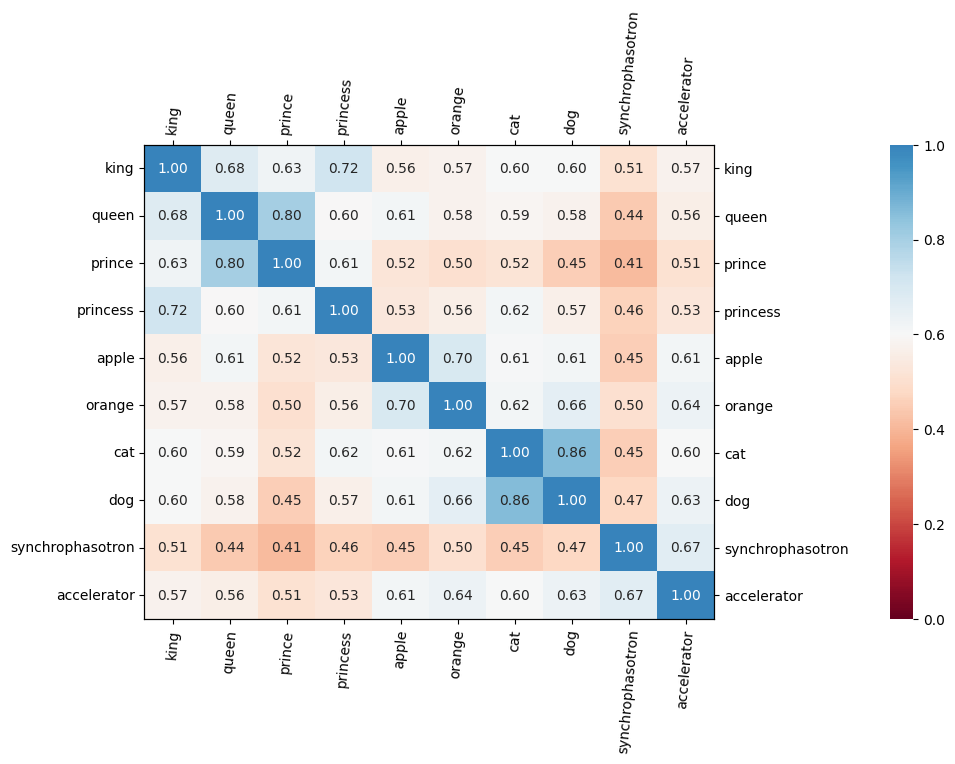

Saving to embedding_correlations.png


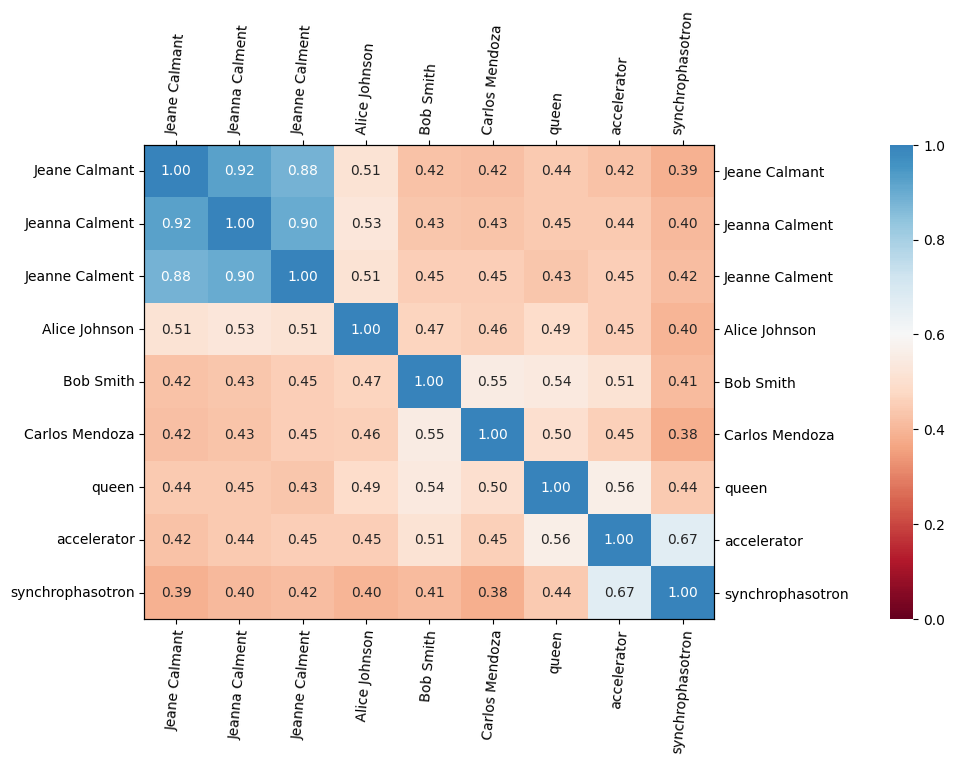

In [5]:
visualize_embedding_correlations(general_terms, model=gte_large, output_path="embedding_correlations_general_terms.png")
visualize_embedding_correlations(names, model=gte_large)


Now let's see how Jina-embedding-v3 performs:

In [6]:
jina_ai_v3 = load_model_from_enum(EmbeddingModel.JINA_EMBEDDINGS_V3)

Saving to embedding_correlations.png


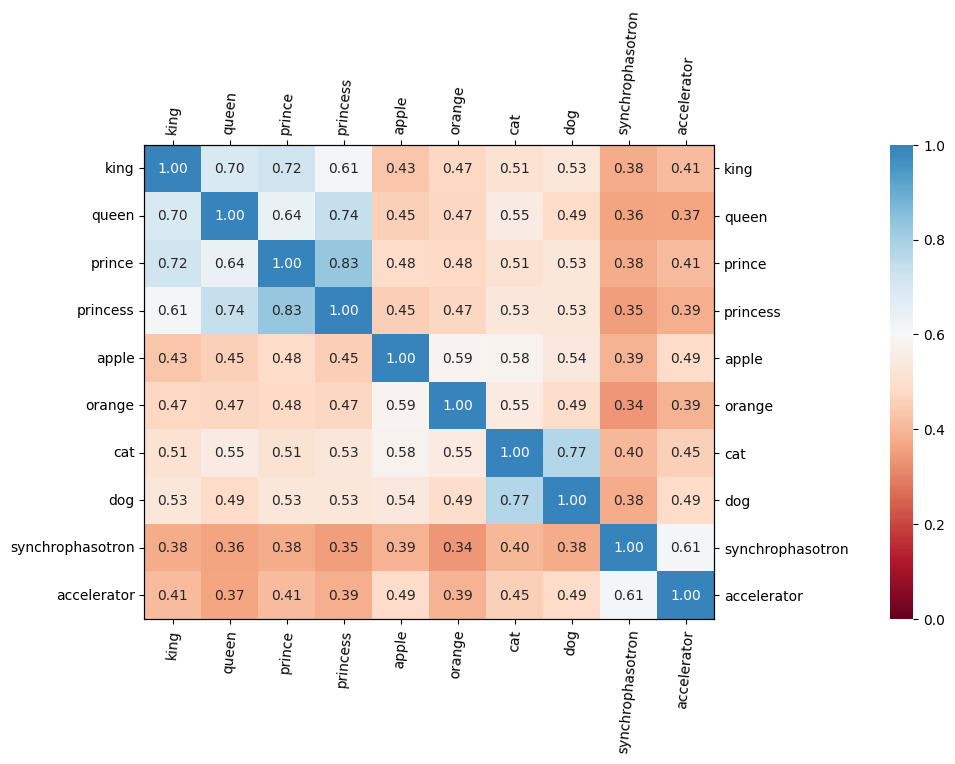

Saving to embedding_correlations.png


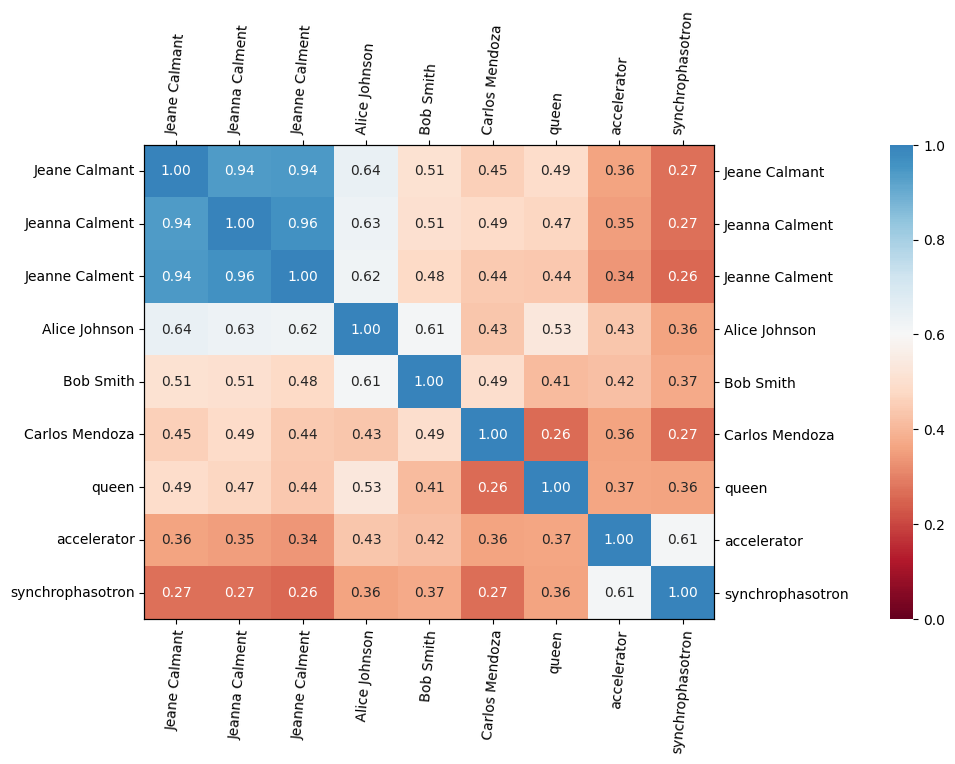

In [7]:
visualize_embedding_correlations(general_terms, model=jina_ai_v3)
visualize_embedding_correlations(names, model=jina_ai_v3)


# Biological embeddings

But how do biological embeddings look like?

We do not have enough time to go through them but let's see hsome of the biological embeddings.

For genomics [BioFM model](https://github.com/m42-health/biofm-eval/) can be a way to go as it is very small and performant:
<img src="https://github.com/m42-health/biofm-eval/blob/main/biotoken_biofm.png?raw=true" alt="LLM Token Prediction">

For Transcriptomics people use models like geneformer where they represent the expression as a sorted (by rank) list of genes. Geneformer is an encoder model that is trained based on masking the genes and traing to guess their ranks. Here is an example of how MouseGeneformer works:
<img src="https://journals.plos.org/plosgenetics/article/file?id=10.1371/journal.pgen.1011420.g001&type=large"  width="50%" alt="LLM Token Prediction">

# Using Just-Semantic-Search

In [8]:
import os
os.environ["MEILISEARCH_HOST"] = "agingkills.eu"
os.environ["MEILISEARCH_API_KEY"] = "c7f758b69b20e4903401480cbff1087aa0e5c568f2e627f02d995d13b1972674"

In [11]:
!pip install dotenv
import dotenv
from just_semantic_search.meili.tools import search_documents
search_documents("Synergistic lifespan interventions", "longevity-jina-v3")

['Title: Background & Summary\n\n\nAgeing is a complex biological phenomenon and a major risk factor for many chronic diseases [1][2][3][4] . Although there are many genes and pathways known to modulate ageing and longevity, the ultimate mechanism by which these pathways affect organismal longevity is not fully understood. Insulin-like growth factor (IGF), mechanistic target of rapamycin (mTOR), AMP-activated protein kinase (AMPK) and sirtuins are among the best-characterized pathways known to regulate longevity and affect ageing trajectories in model organisms 5,6 . An increasing number of drugs and drug-like molecules, including human drugs such as metformin and rapamycin, have been identified to target pathways involved in ageing and longevity and these compounds are known to extend lifespan and health span in model organisms [7][8][9][10] . The observation that such benefits are conserved over large evolutionary distances suggests that similar pro-longevity and health span effect m

In [ ]:
import os
import getpass
from dotenv import load_dotenv

def get_api_keys():
  """Gets API keys from the user."""
  load_dotenv(override=True)

  # Check if GROQ_API_KEY is already set in environment
  groq_api_key = os.environ.get("GROQ_API_KEY")
  gemini_api_key = os.environ.get("GEMINI_API_KEY")

  # Only prompt for key if not already set
  if not groq_api_key:
    print("Please enter your API keys:")
    groq_api_key = getpass.getpass("GROQ_API_KEY: ")
    # Set environment variable
    os.environ["GROQ_API_KEY"] = groq_api_key
    print("GROQ_API key set successfully.")
  else:
    print("GROQ API key already set in environment.")


  # Only prompt for key if not already set
  if not gemini_api_key:
    print("Please enter your API keys:")
    gemini_api_key = getpass.getpass("GEMINI_API_KEY: ")
    # Set environment variable
    os.environ["GEMINI_API_KEY"] = gemini_api_key
    print("GEMINI_API key set successfully.")
  else:
    print("GEMINI API key already set in environment.")


# Call the function to get API keys from the user
get_api_keys()

In [13]:
!pip install just_agents==0.7.4
from just_agents.base_agent import BaseAgent
from just_agents import llm_options

search_agent = BaseAgent(
    llm_options=llm_options.LLAMA3_3,
    tools=[search_documents]
)

prompt = "Search for documents about synergistic lifespan interventions in the longevity-jina-v3 index."
response = search_agent.query(prompt)
print(response)
search_agent.memory.pretty_print_all_messages()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.0/647.0 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 

BadRequestError: litellm.BadRequestError: GroqException - {"error":{"message":"Invalid API Key","type":"invalid_request_error","code":"invalid_api_key"}}
